In [13]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [14]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks
set_seed(seed=42)

Random seed set to 42


In [15]:
load_fraction = 1.0
batch_size = 64
image_size = (224, 224)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations={
        'rotation': 5,       # Rotate up to ±5 degrees
        'brightness': True,  # Random brightness adjustment
        'contrast': True,    # Random contrast adjustment
        'scaling': True,     # Random scaling (zoom)
        'translation': True, # Random translation (shift)
        'blur': True         # Apply Gaussian blur
    },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

# # Get the first batch
X, y = train_generator[0]

# # Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

11 batches created, each of size 64, with 663 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (64, 30, 224, 224, 3)
Labels batch shape (y): (64, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]
2 batches created, each of size 64, with 100 sequences of 30 images each. Use MediaPipe: False


In [16]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # input shape

In [17]:
from tensorflow.keras.applications import MobileNetV3Small

# Updated Pretrained CNN as feature extractor
cnn_base = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))
cnn_base.trainable = False  # Keep the pretrained layers frozen
cnn_base.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Dropout, Dense, MaxPooling2D, Flatten, Input

# Updated model
model = Sequential([
    Input(shape=(30, 224, 224, 3), name="Input_Layer"),                             # Input layer for sequences of 30 frames
    TimeDistributed(cnn_base, name="CNN_Layer"),                                    # CNN base to process each frame independently
    TimeDistributed(MaxPooling2D(), name="MaxPooling_Layer"),                      # Max Pooling to reduce spatial dimensions
    TimeDistributed(Flatten(), name="Flatten_Layer"),                              # Flatten spatial dimensions into feature vectors
    GRU(64, return_sequences=False, name="GRU_Layer"),                             # GRU for temporal feature extraction
    Dropout(0.5, name="Dropout_Layer"),                                            # Dropout for regularization
    Dense(5, activation="softmax", name="Output_Layer")                            # Dense layer for 5 gesture classes
], name="CNN_GRU_Model")

# Compile the model
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
model.summary()

Model: "CNN_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_Layer (TimeDistributed)     │ (None, 30, 7, 7, 576)  │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_Layer                │ (None, 30, 3, 3, 576)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (TimeDistributed) │ (None, 30, 5184)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_Layer (GRU)                 │ (None, 64)             │     1,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,947,445 (7.43 MB)

 Trainable params: 1,008,325 (3.85 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [19]:
model_save_location = 'best-models/pretrained-MobileNetV3Small+GRU.keras'

In [20]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step - accuracy: 0.2107 - loss: 2.1163 - val_accuracy: 0.2300 - val_loss: 1.7368 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.1812 - loss: 1.9930 - val_accuracy: 0.2100 - val_loss: 1.6285 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.1870 - loss: 1.8484 - val_accuracy: 0.1800 - val_loss: 1.6266 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.2197 - loss: 1.8943 - val_accuracy: 0.2100 - val_loss: 1.6381 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.2093 - loss: 1.8125 - val_accuracy: 0.2100 - val_loss: 1.6643 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.2175 - loss: 1.8038 - val_accuracy: 0.3600 - val_loss: 1.6110 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.2253 - loss: 1.7233 - val_accuracy

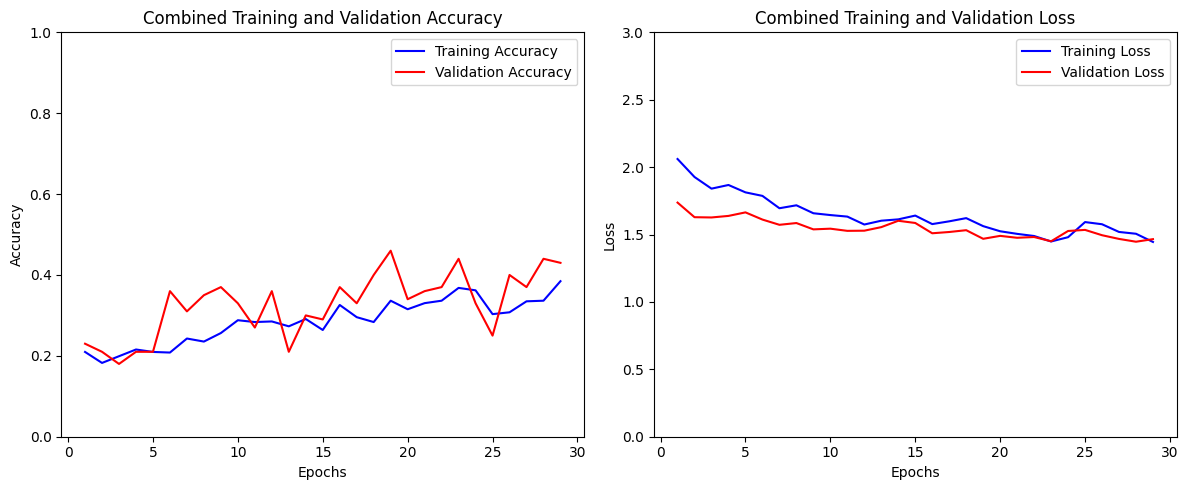

In [21]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

In [22]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_2 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=40,                   # Train for more epochs
#     initial_epoch=30,            # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2])